In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


%matplotlib inline

In [2]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [3]:
# Import data
#DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv("CHURN.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print(f"Rows: ", df.shape[0])
print(f"Columns: ", df.shape[1])

Rows:  7043
Columns:  21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# number of unique observations per column
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [8]:
# eliminate 'customerID'
df.drop('customerID', axis=1, inplace=True)

In [9]:
print(f"Cells filled with whitespace in 'TotalCharges' (Before): ", len(df[df['TotalCharges'] == ' ']))

Cells filled with whitespace in 'TotalCharges' (Before):  11


In [10]:
# replace whitespaces by null values 
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = np.nan
print(f"Cells filled with whitespace in 'TotalCharges' (After): ", len(df[df['TotalCharges'] == ' ']))

Cells filled with whitespace in 'TotalCharges' (After):  0


In [11]:
# replace null values by the median of 'TotalCharges'
TotalCharges_median = df['TotalCharges'].median()
df['TotalCharges'].fillna(TotalCharges_median, inplace=True)

In [12]:
# convert 'TotalCharges' from string to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [13]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


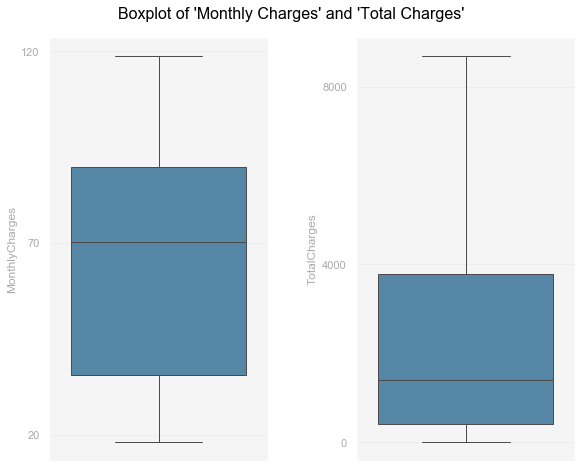

In [14]:
# draw a boxplot to check for outliers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 7))
fig.suptitle("Boxplot of 'Monthly Charges' and 'Total Charges'")

boxprops = whiskerprops = capprops = medianprops = dict(linewidth=1)

sns.boxplot(df['MonthlyCharges'], orient='v', color='#488ab5', ax=ax[0], 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops)
ax[0].set_facecolor('#f5f5f5')
ax[0].set_yticks([20, 70, 120])

sns.boxplot(df['TotalCharges'], orient='v', color='#488ab5', ax=ax[1],
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops)
ax[1].set_facecolor('#f5f5f5')
ax[1].set_yticks([0, 4000, 8000])

plt.tight_layout(pad=4.0);

In [15]:
print(df['Churn'].value_counts())
print('\nTotal Churn Rate: {:.2%}'.format(df[df['Churn'] == 'Yes'].shape[0] / df.shape[0]))

No     5174
Yes    1869
Name: Churn, dtype: int64

Total Churn Rate: 26.54%


In [16]:
# unique values for each column containing a categorical feature
def unique_values():
  cat_columns = np.unique(df.select_dtypes('object').columns)
  for i in cat_columns:
    print(i, df[i].unique())

unique_values()

Churn ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No' 'Yes' 'No internet service']
InternetService ['DSL' 'Fiber optic' 'No']
MultipleLines ['No phone service' 'No' 'Yes']
OnlineBackup ['Yes' 'No' 'No internet service']
OnlineSecurity ['No' 'Yes' 'No internet service']
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
PhoneService ['No' 'Yes']
StreamingMovies ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
gender ['Female' 'Male']


In [17]:
# switch 'No inernet service to 'No'
to_binary = ['DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'StreamingMovies', 'StreamingTV', 'TechSupport']

for i in to_binary:
  df.loc[df[i].isin(['No internet service']), i] = 'No'

In [18]:
unique_values()

Churn ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
MultipleLines ['No phone service' 'No' 'Yes']
OnlineBackup ['Yes' 'No']
OnlineSecurity ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
PhoneService ['No' 'Yes']
StreamingMovies ['No' 'Yes']
StreamingTV ['No' 'Yes']
TechSupport ['No' 'Yes']
gender ['Female' 'Male']


In [19]:
df.loc[df['Churn'] == 'No','Churn'] = 0 
df.loc[df['Churn'] == 'Yes','Churn'] = 1
df['Churn'] = df['Churn'].astype(int)

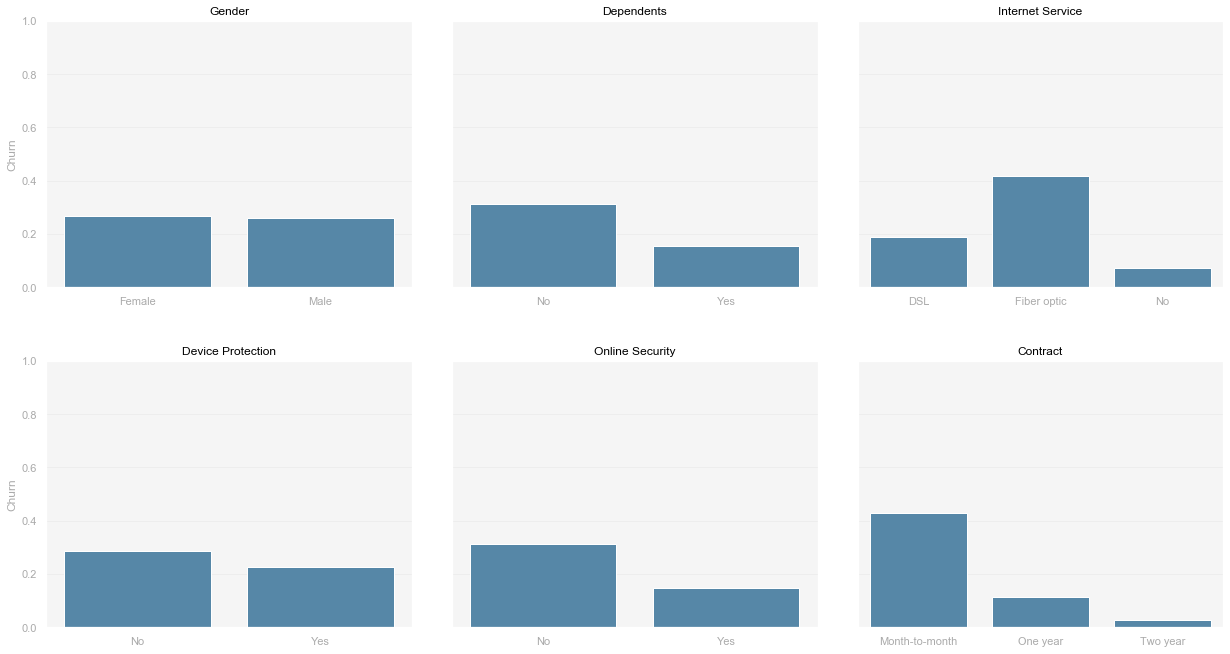

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

sns.barplot(df['gender'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][0])
ax[0][0].set_facecolor('#f5f5f5')
ax[0][0].set_ylim(0,1)
ax[0][0].set_xlabel(None)
ax[0][0].set_title('Gender')

sns.barplot(df['Dependents'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][1])
ax[0][1].set_facecolor('#f5f5f5')
ax[0][1].tick_params(labelleft=False)
ax[0][1].set_ylim(0,1)
ax[0][1].set_ylabel(None)
ax[0][1].set_xlabel(None)
ax[0][1].set_title('Dependents')

sns.barplot(df['InternetService'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][2])
ax[0][2].set_facecolor('#f5f5f5')
ax[0][2].tick_params(labelleft=False)
ax[0][2].set_ylim(0,1)
ax[0][2].set_ylabel(None)
ax[0][2].set_xlabel(None)
ax[0][2].set_title('Internet Service')

sns.barplot(df['DeviceProtection'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][0])
ax[1][0].set_facecolor('#f5f5f5')
ax[1][0].set_ylim(0,1)
ax[1][0].set_xlabel(None)
ax[1][0].set_title('Device Protection')

sns.barplot(df['OnlineSecurity'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][1])
ax[1][1].set_facecolor('#f5f5f5')
ax[1][1].tick_params(labelleft=False)
ax[1][1].set_ylim(0,1)
ax[1][1].set_ylabel(None)
ax[1][1].set_xlabel(None)
ax[1][1].set_title('Online Security')

sns.barplot(df['Contract'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][2])
ax[1][2].set_facecolor('#f5f5f5')
ax[1][2].tick_params(labelleft=False)
ax[1][2].set_ylim(0,1)
ax[1][2].set_ylabel(None)
ax[1][2].set_xlabel(None)
ax[1][2].set_title('Contract')

plt.tight_layout(pad=4.0)

In [21]:
# list of binary variables, except 'Churn'
bin_var = [col for col in df.columns if len(df[col].unique()) == 2 and col != 'Churn']

# list of categorical variables
cat_var = [col for col in df.select_dtypes(['object']).columns.tolist() if col not in bin_var]

# apply Label Encoding for binaries
le = LabelEncoder()
for col in bin_var:
  df[col] = le.fit_transform(df[col])

# apply get_dummies for categorical
df = pd.get_dummies(df, columns=cat_var)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,1,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


# Machine Learning Models

In [22]:
# feature matrix
X = df.drop('Churn', axis=1)
# target vector
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

In [24]:
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()

model = []
cross_val = []
recall = []
for i in (svc, lr, xgb):
  model.append(i.__class__.__name__)
  cross_val.append(cross_validate(i, X_train_rus, y_train_rus, scoring='recall'))
  
for d in range(len(cross_val)):
  recall.append(cross_val[d]['test_score'].mean())

In [25]:
model_recall = pd.DataFrame
pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
SVC,0.782290
LogisticRegression,0.792982
XGBClassifier,0.748048


              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1293
           1       0.49      0.78      0.60       468

    accuracy                           0.73      1761
   macro avg       0.70      0.75      0.70      1761
weighted avg       0.79      0.73      0.74      1761



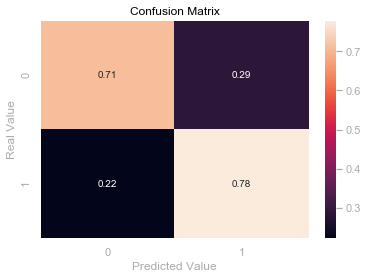

In [28]:
# final SVC model
svc = SVC(kernel='poly', C=1.0)
svc.fit(X_train_rus, y_train_rus)

# prediction
X_test_svc = scaler.transform(X_test)
y_pred_svc = svc.predict(X_test_svc)

# classification report
print(classification_report(y_test, y_pred_svc))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_svc, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('Real Value')
ax.set_xlabel('Predicted Value')

plt.show()

              precision    recall  f1-score   support

           0       0.93      0.67      0.78      1293
           1       0.48      0.85      0.62       468

    accuracy                           0.72      1761
   macro avg       0.70      0.76      0.70      1761
weighted avg       0.81      0.72      0.73      1761



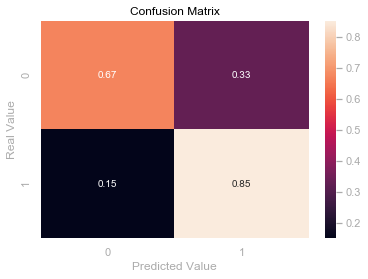

In [29]:
# final Logistic Regression model
lr = LogisticRegression(solver='liblinear', C=0.0001)
lr.fit(X_train_rus, y_train_rus)

# prediction
X_test_lr = scaler.transform(X_test)
y_pred_lr = lr.predict(X_test_lr)

# classification report
print(classification_report(y_test, y_pred_lr))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lr, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('Real Value')
ax.set_xlabel('Predicted Value')

plt.show()

              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1293
           1       0.45      0.88      0.59       468

    accuracy                           0.68      1761
   macro avg       0.69      0.74      0.66      1761
weighted avg       0.81      0.68      0.70      1761



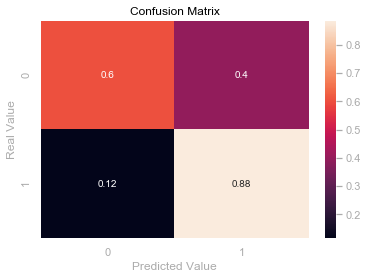

In [30]:
# final XGBoost model
xgb = XGBClassifier(learning_rate=0.0001, n_estimators=25, max_depth=1, min_child_weight=0.0001, gamma=0)
xgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('Real Value')
ax.set_xlabel('Predicted Value')

plt.show()